### Problem Statement
- Different activities(activity.csv) taken by different people(people.csv) cause different outcome.

### Objectives
- The prediction process learns characteristics of people and activity to predict the coutcome.

In [49]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 4

### Load datasets

In [302]:
people = pd.read_csv('./data/people.csv', parse_dates=['date'])
activity = pd.read_csv('./data/act_train.csv', parse_dates=['date'])
people.shape, activity.shape

((189118, 41), (2197291, 15))

In [487]:
# join dataset by people id
data = activity.merge(people, on='people_id', how='inner', suffixes=('_act', '_ppl'))
data.shape

(2197291, 55)

In [488]:
data.head()

,people_id,activity_id,date_act,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36
3,ppl_100,act2_3651215,2023-08-04,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36
4,ppl_100,act2_4109017,2023-08-26,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36


### Remove prefix of variables

In [173]:
def remove_prefix(char):
    """Remove the 'type' or 'group' prefix of 'char_*' , 'activity_category', and 'group'
    """
    if char and str(char).startswith('type'):
        return char[5:]
    if char and str(char).startswith('group'):
        return char[6:]
    else:
        return

In [489]:
for col in data.columns[data.dtypes == 'object'] - ['people_id', 'activity_id', 'date_act', 'date_ppl', 'outcome', 'char_38']:
    print 'remove the prefix of feature: {}'.format(col)
    data[col] = data[col].apply(remove_prefix)
    print '======================================='

remove the prefix of feature: activity_category
remove the prefix of feature: char_10_act
remove the prefix of feature: char_1_act
remove the prefix of feature: char_1_ppl
remove the prefix of feature: char_2_act
remove the prefix of feature: char_2_ppl
remove the prefix of feature: char_3_act
remove the prefix of feature: char_3_ppl
remove the prefix of feature: char_4_act
remove the prefix of feature: char_4_ppl
remove the prefix of feature: char_5_act
remove the prefix of feature: char_5_ppl
remove the prefix of feature: char_6_act
remove the prefix of feature: char_6_ppl
remove the prefix of feature: char_7_act
remove the prefix of feature: char_7_ppl
remove the prefix of feature: char_8_act
remove the prefix of feature: char_8_ppl
remove the prefix of feature: char_9_act
remove the prefix of feature: char_9_ppl
remove the prefix of feature: group_1


In [492]:
data.shape

(2197291, 55)

In [491]:
# fillna with as type 0
data.fillna(0, inplace=True)
data.head()

,people_id,activity_id,date_act,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,act2_1734928,2023-08-26,4,0,0,0,0,0,0,...,False,True,True,False,False,True,True,True,False,36
1,ppl_100,act2_2434093,2022-09-27,2,0,0,0,0,0,0,...,False,True,True,False,False,True,True,True,False,36
2,ppl_100,act2_3404049,2022-09-27,2,0,0,0,0,0,0,...,False,True,True,False,False,True,True,True,False,36
3,ppl_100,act2_3651215,2023-08-04,2,0,0,0,0,0,0,...,False,True,True,False,False,True,True,True,False,36
4,ppl_100,act2_4109017,2023-08-26,2,0,0,0,0,0,0,...,False,True,True,False,False,True,True,True,False,36


### Data sampling for EDA

In [518]:
# sample 2% of total data for exploratory data analysis
np.random.seed(1234)
random_idx = np.random.choice(activity.index.values, len(data)/50, replace=False)
sample_data = data.iloc[random_idx]
sample_data.shape

(43945, 55)

### Check the label outcome distribution

0    24511
1    19434
Name: outcome, dtype: int64


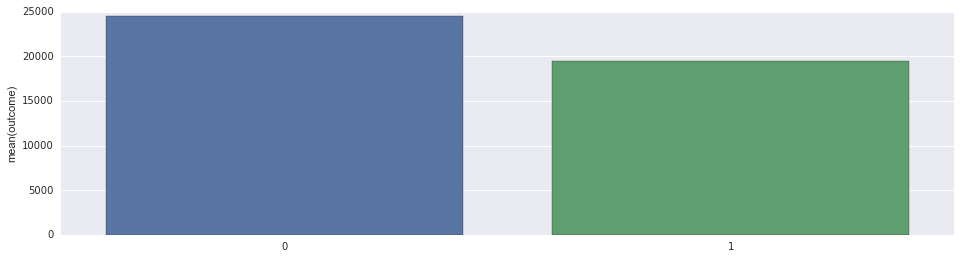

In [521]:
outcome = sample_data.outcome.value_counts()
print outcome
sns.barplot(x= outcome.index, y = outcome)

- The outcome is binary and has a balanced distribution, a good news.

### Check the cardinality of each categorical feature

In [522]:
sample_data[sample_data.columns - ['people_id', 'activity_id', 'outcome', 'date_act', 'date_ppl']].apply(lambda col : len(col.unique()))

activity_category       7
char_10_act          2407
char_10_ppl             2
char_11                 2
char_12                 2
char_13                 2
char_14                 2
char_15                 2
char_16                 2
char_17                 2
char_18                 2
char_19                 2
char_1_act             40
char_1_ppl              2
char_20                 2
char_21                 2
char_22                 2
char_23                 2
char_24                 2
char_25                 2
char_26                 2
char_27                 2
char_28                 2
char_29                 2
char_2_act             28
char_2_ppl              3
char_30                 2
char_31                 2
char_32                 2
char_33                 2
char_34                 2
char_35                 2
char_36                 2
char_37                 2
char_38               101
char_3_act             11
char_3_ppl             41
char_4_act              7
char_4_ppl  

-  char_10_act, char_38, and group_1 have hight cardinalty

### Barplot the features with low cardinality

In [523]:
cgr_cols_low = sample_data.columns - ['people_id', 'activity_id', 'date_act', 'date_ppl', 'char_10_act', 'char_38', 'group_1']

In [524]:
def plot_cgr(cgr_data, cols):
    """function to barplot the categorical features by 'outcome'
    """
    plt.figure(figsize=(16, 4*len(cols)))
    for idx, col in enumerate(cols):
        idx = idx + 1
        ax = plt.subplot(len(cols),1,idx)
        sns.countplot(x=col, hue="outcome", data=cgr_data, ax=ax)
        ax.set_title('Outcome Distribution by {}'.format(col))
    plt.tight_layout()
    plt.show()
    plt.close()

- barplot the activity features with low cardinality

In [526]:
cgr_cols_low_act = filter(None, [col if str(col).endswith('act') else '' for col in cgr_cols_low])
cgr_cols_low_act.append('activity_category')
cgr_cols_low_act

['char_1_act',
 'char_2_act',
 'char_3_act',
 'char_4_act',
 'char_5_act',
 'char_6_act',
 'char_7_act',
 'char_8_act',
 'char_9_act',
 'activity_category']

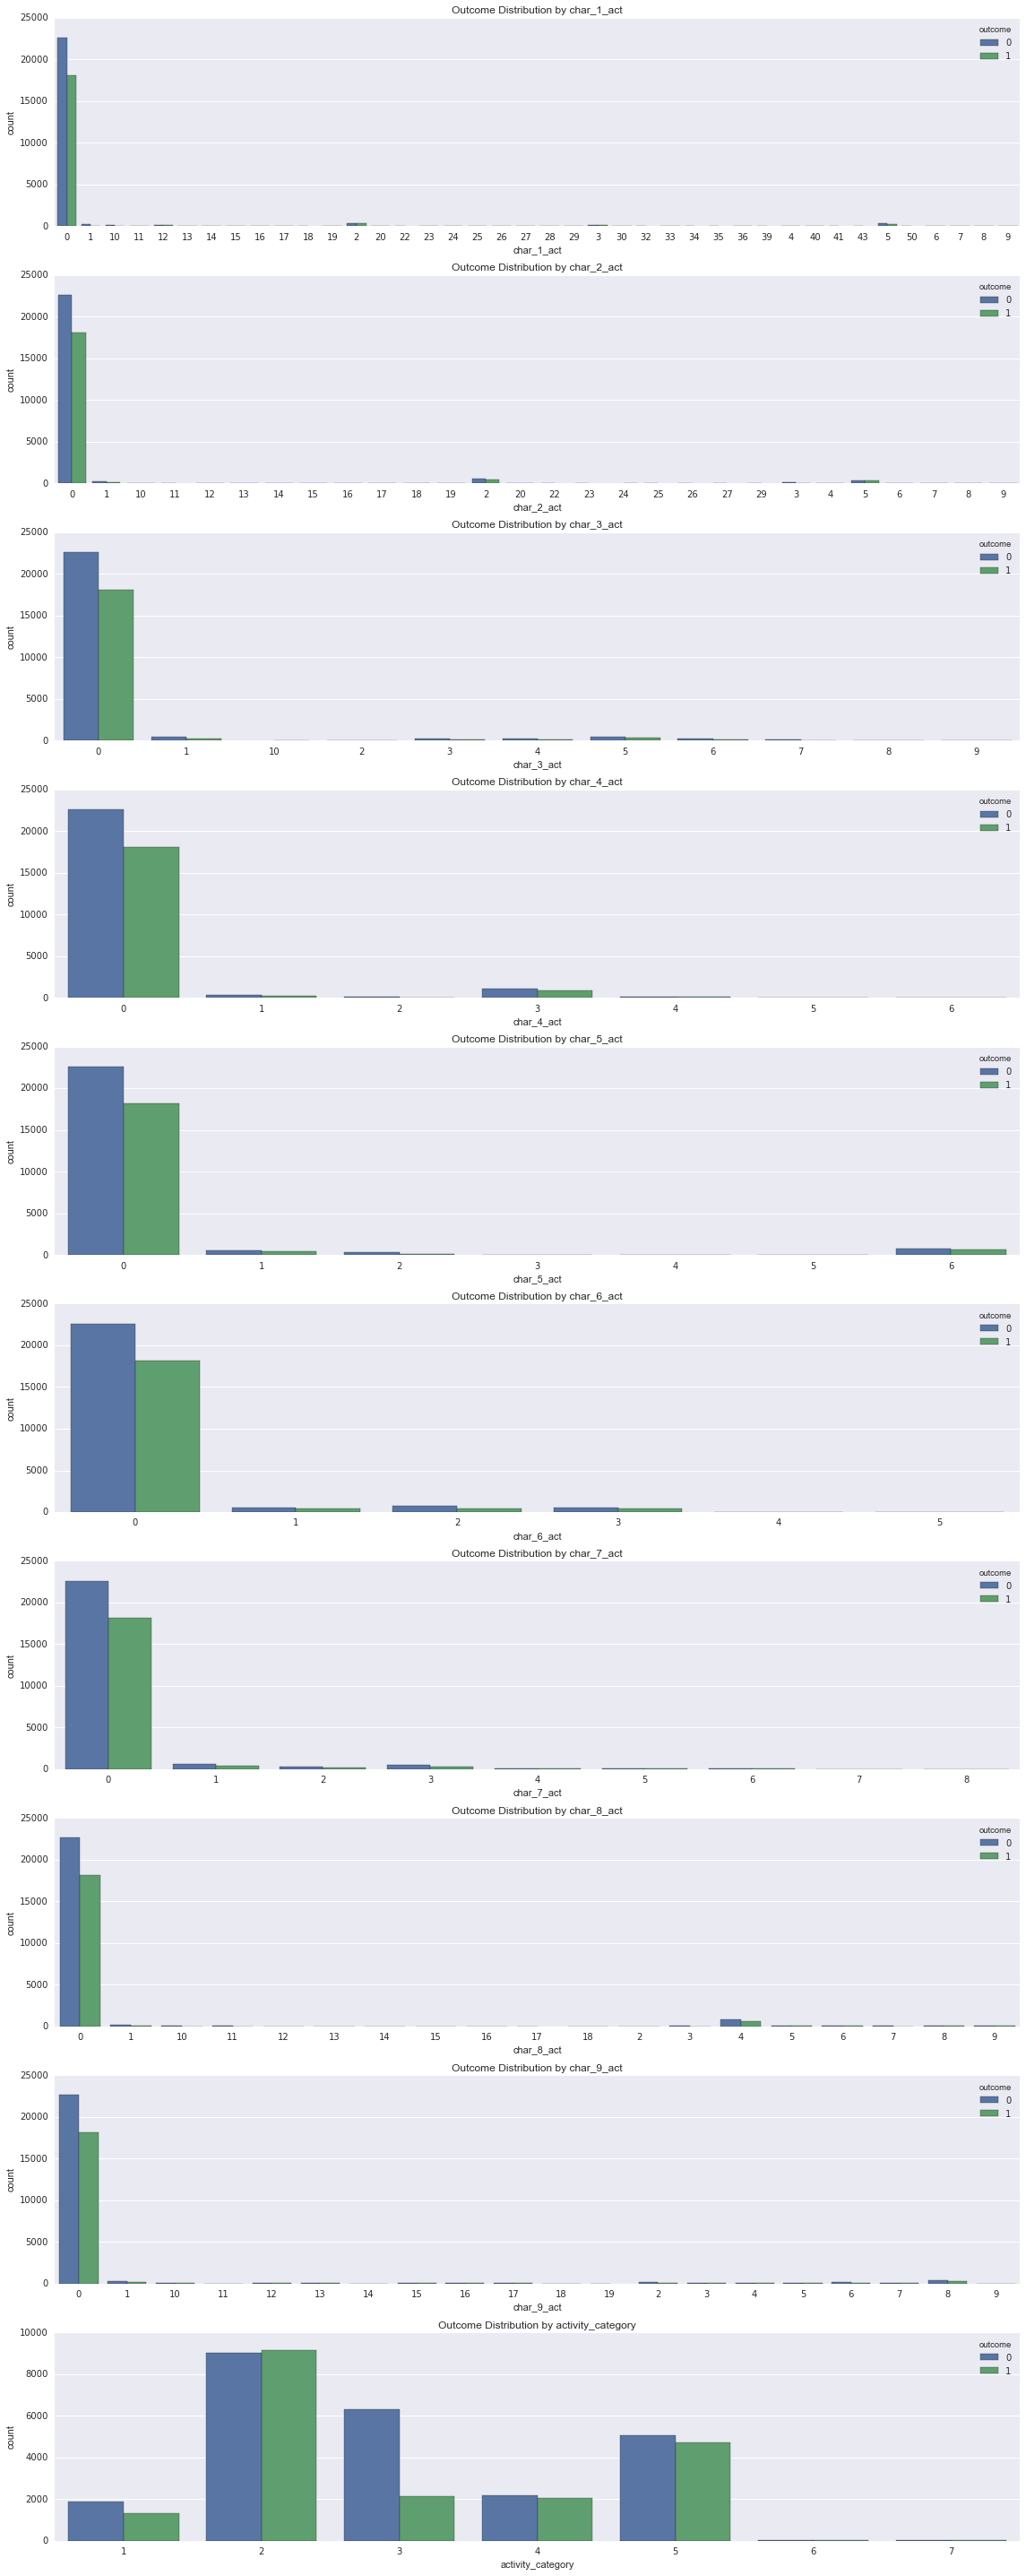

In [527]:
plot_cgr(sample_data, cgr_cols_low_act)

- In actitivty 'char_*', the majority type is 0, the 'NaNs' imputed before
- In the type 0, the outcome is nearly balanced, and outcome 0 exceeds 1 in all features
- 'activity_category' is an exception with more variance across categories

- barplot the people features with low cardinality

In [528]:
cgr_cols_low_ppl = cgr_cols_low - cgr_cols_low_act
cgr_cols_low_ppl = cgr_cols_low_ppl - ['outcome']

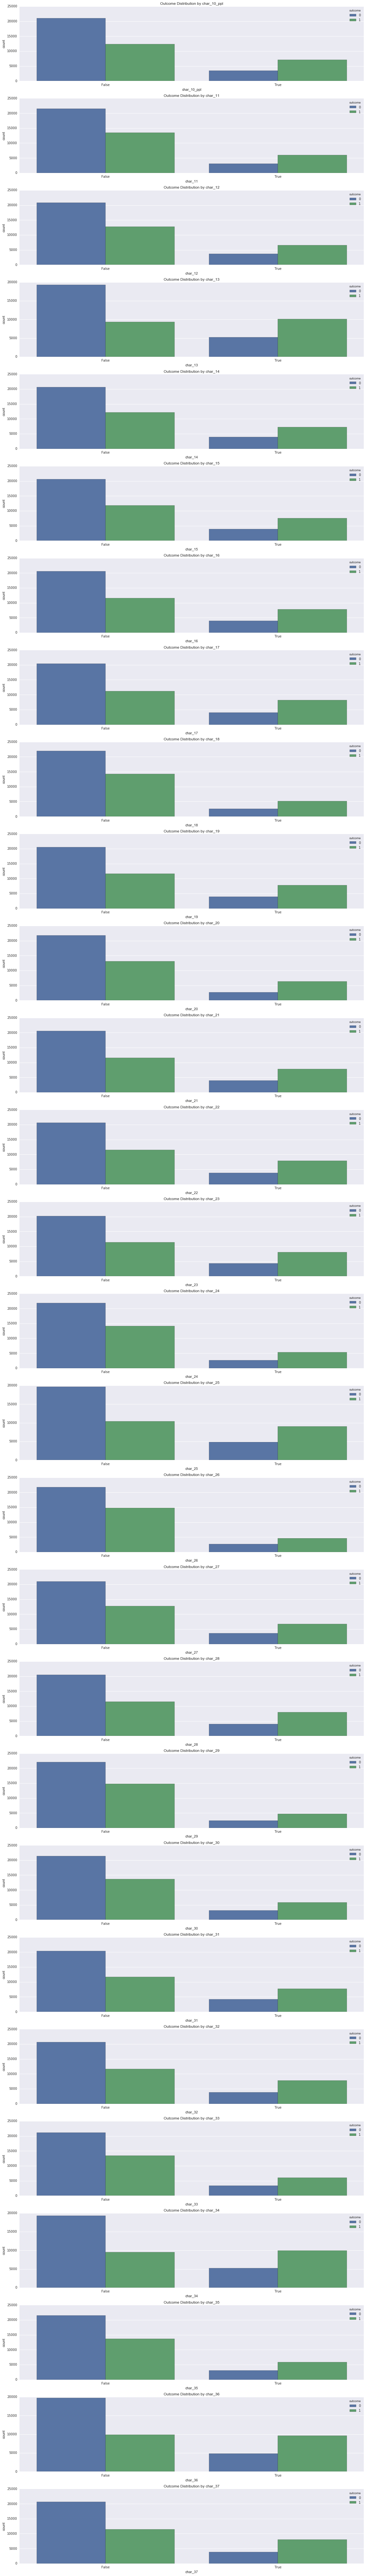

In [529]:
# first barplot the boolean types
cgr_cols_low_ppl_bool = cgr_cols_low_ppl[sample_data[cgr_cols_low_ppl].dtypes == 'bool']
plot_cgr(sample_data, cgr_cols_low_ppl_bool)

- Boolean types have pretty similar structure between 'False' and 'True'.
- 'False' exceeds 'True' in total volumn
- The outcome within each boolean characteristic is opposite position, in another way, False tends to end up with 0 outcome, while 'True' tends to end up with  1 outcome.

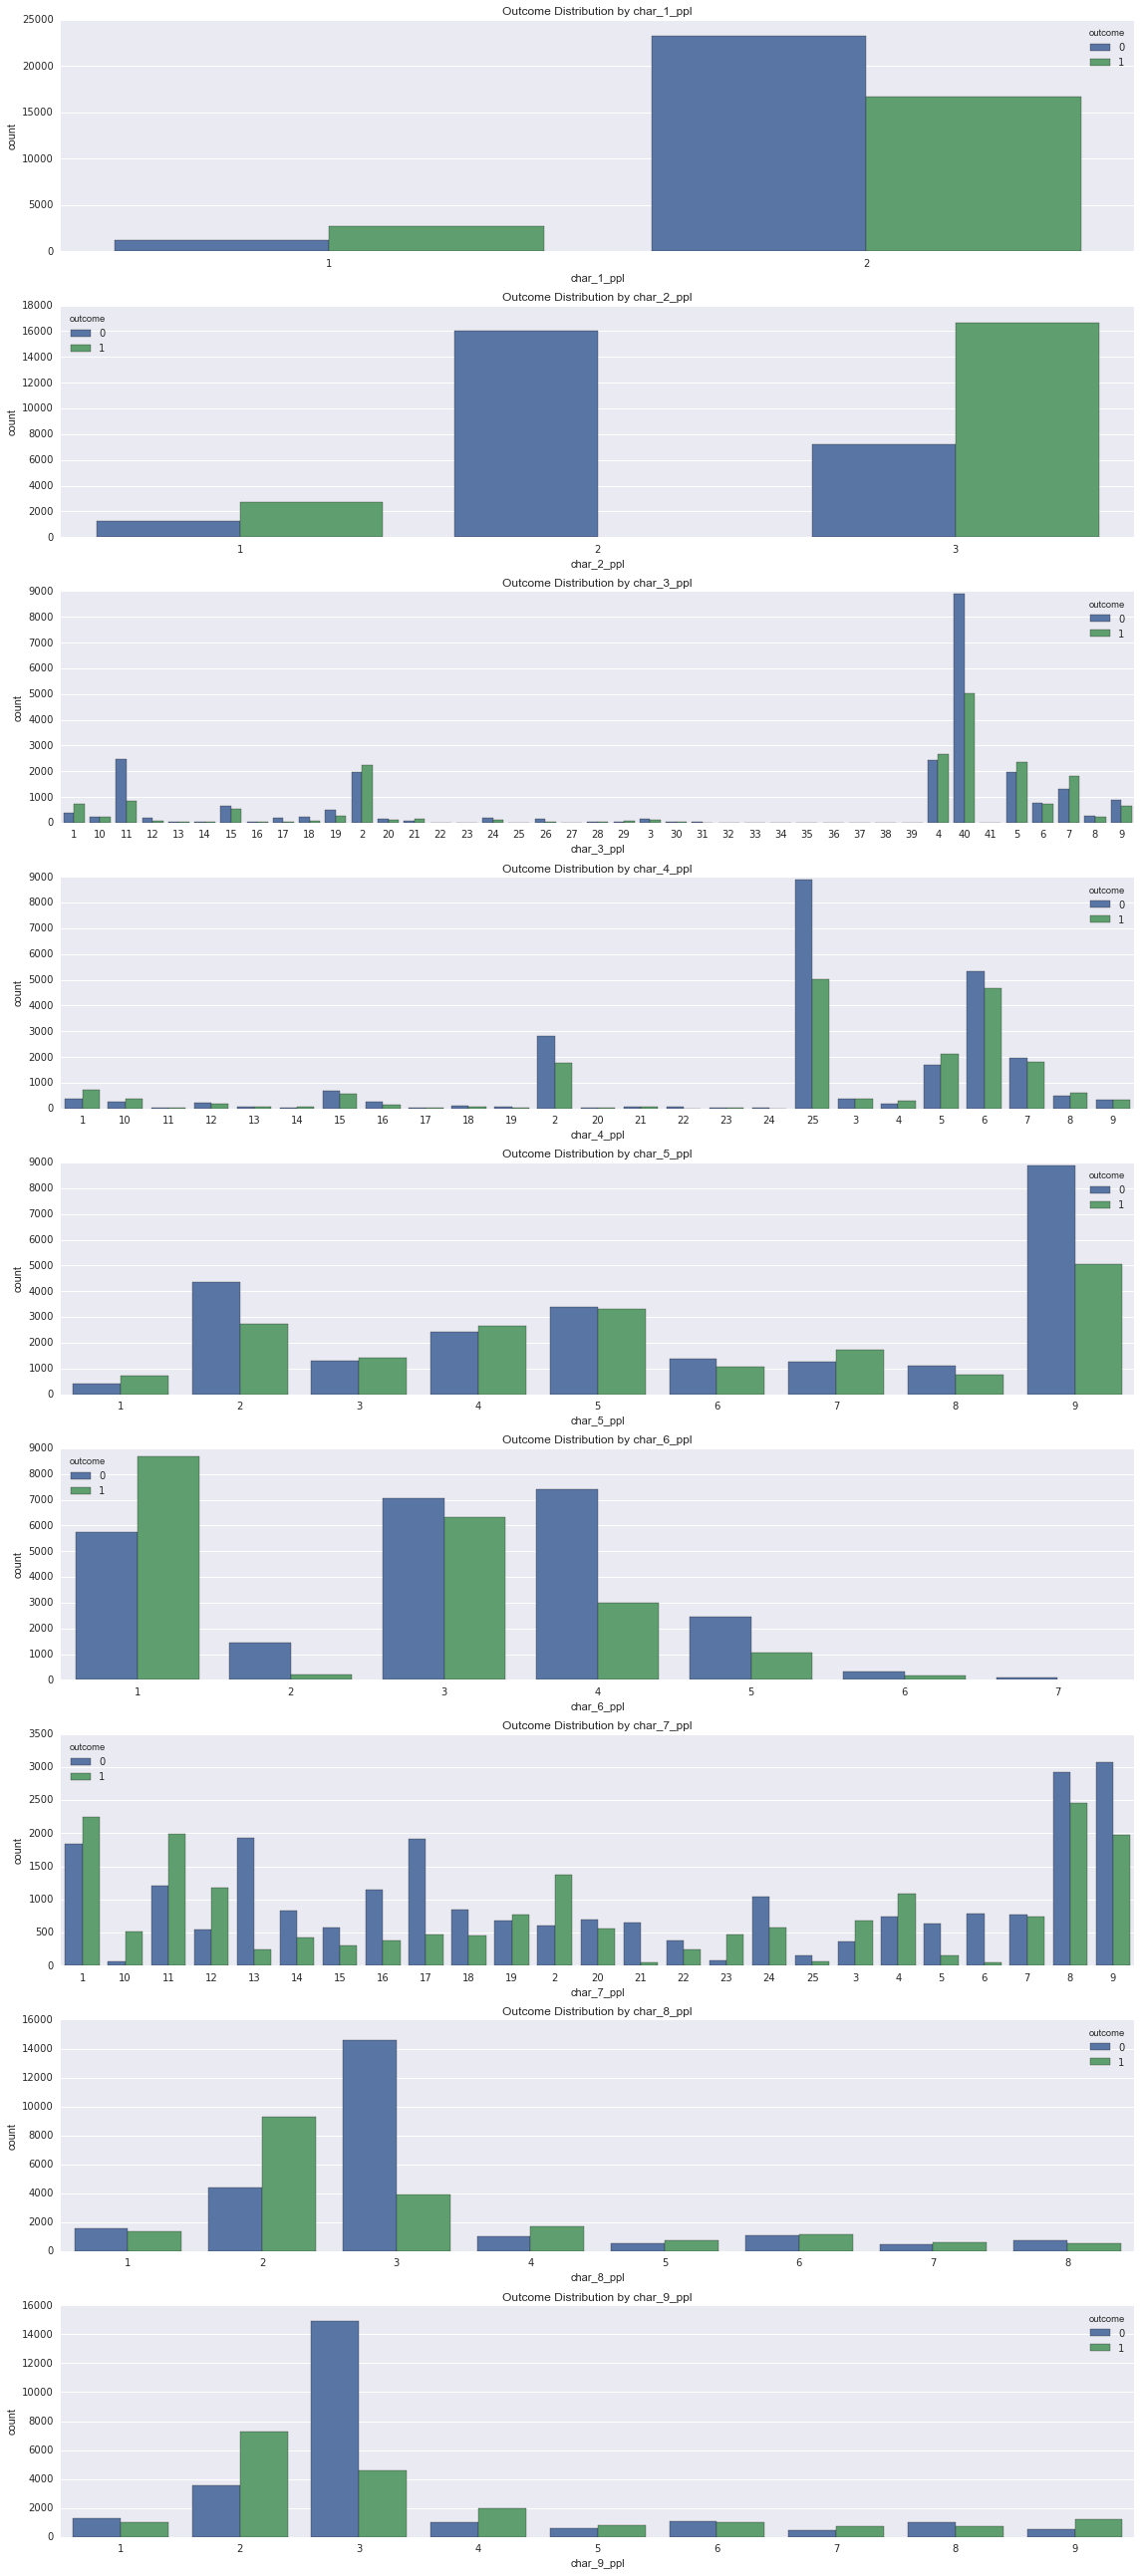

In [530]:
# second, barplot the non-boolean features
cgr_cols_low_ppl_nonbool = cgr_cols_low_ppl[sample_data[cgr_cols_low_ppl].dtypes != 'bool']
plot_cgr(sample_data, cgr_cols_low_ppl_nonbool)

- Non-boolean features are more variant in each features, which could provide important information for the modeling.

### Barplot the features with high cardinality

In [531]:
cgr_cols_high = ['char_10_act', 'char_38', 'group_1']

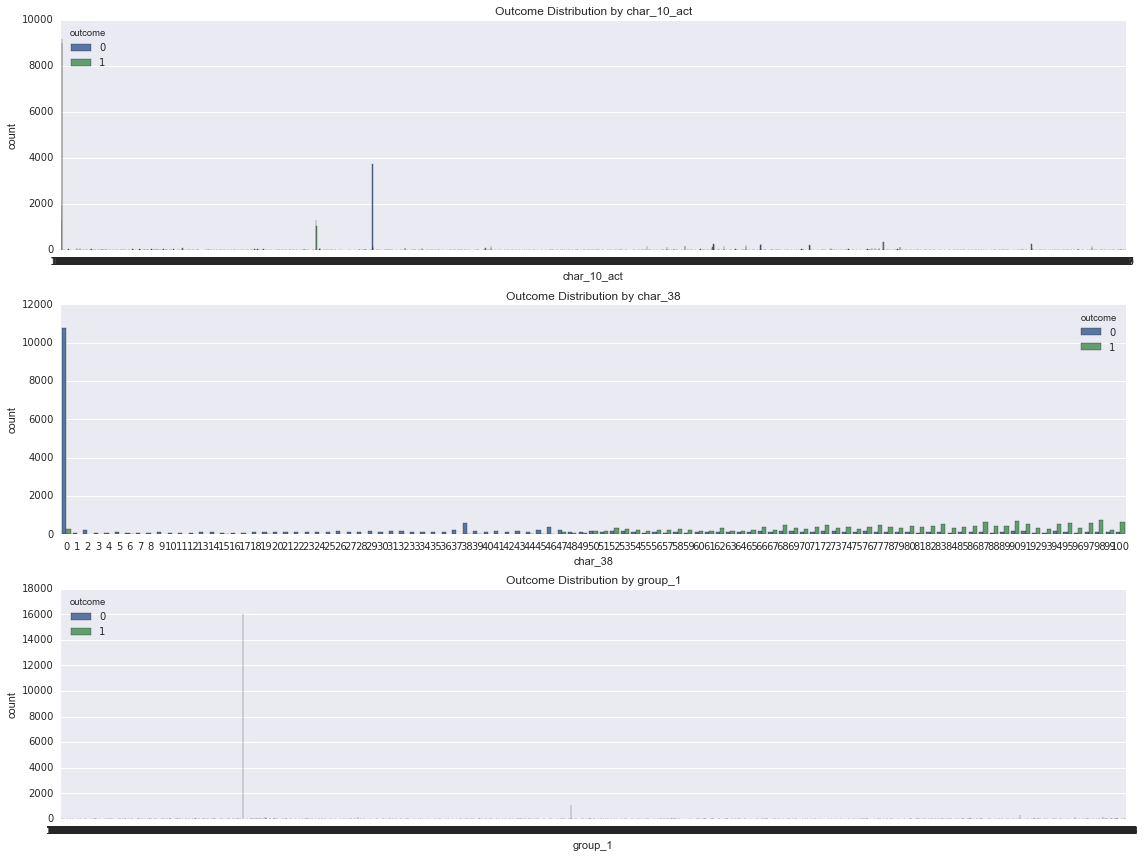

In [532]:
plot_cgr(sample_data, cgr_cols_high)

- All three features have a few extreme high values

### Check the datatime features

In [533]:
# prepare the activity date mean and size
date_act = pd.DataFrame()
date_act['outcome_proba'] = sample_data.groupby('date_act')['outcome'].mean()
date_act['outcome_count'] = sample_data.groupby('date_act')['outcome'].size()

In [534]:
# prepare the people date mean and size
date_ppl = pd.DataFrame()
date_ppl['outcome_proba'] = sample_data.groupby('date_ppl')['outcome'].mean()
date_ppl['outcome_count'] = sample_data.groupby('date_ppl')['outcome'].size()

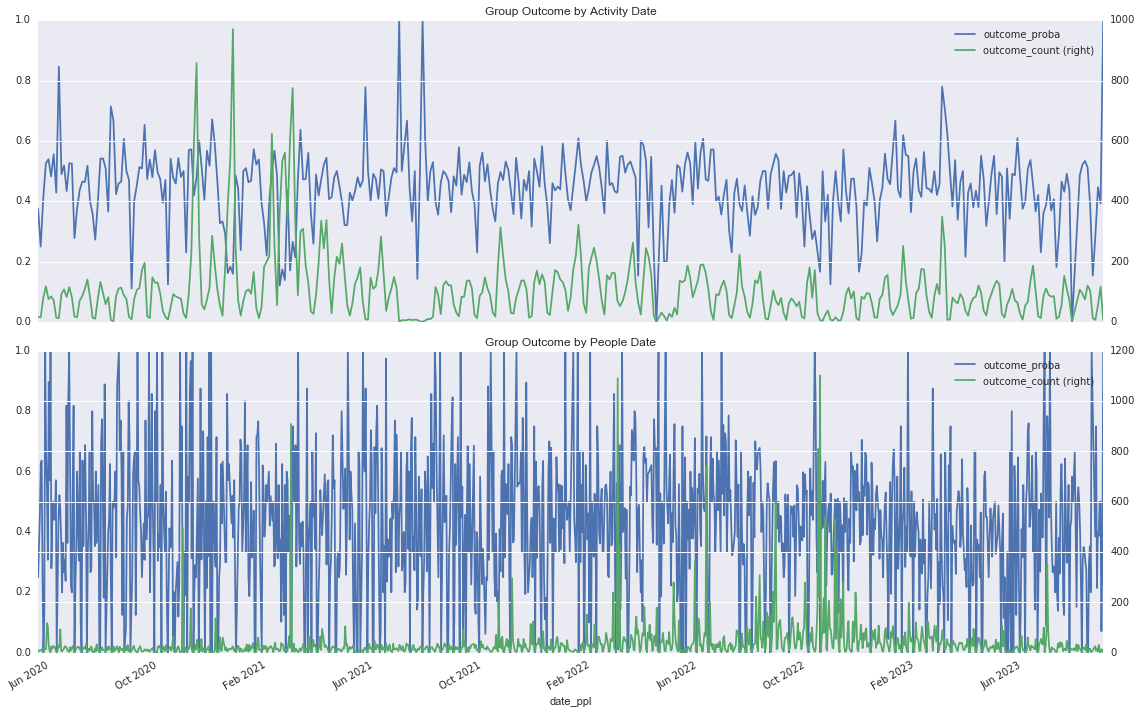

In [535]:
plt.figure()
ax1 = plt.subplot(2,1,1)
date_act.plot(secondary_y='outcome_count', figsize=(16, 10), ax=ax1)
ax1.set_title('Group Outcome by Activity Date')
           
ax2 = plt.subplot(2,1,2)
date_ppl.plot(secondary_y='outcome_count', figsize=(16, 10), ax=ax2)
ax2.set_title('Group Outcome by People Date')


plt.tight_layout()
plt.show()
plt.close()

- The data covers three years records between 2020 and 2023.
- The outcome vibrates periodically along the time series. We can go deeper later to find out if it's weekly or monthly. 
- The blue line(outcome proba) vibrates around 0.5, showing either 1 or 0 occurs evenly

- Plot outcome by week and month

In [536]:
sample_data['dayofweek']= sample_data['date_act'].dt.dayofweek
week_act = pd.DataFrame()
week_act['outcome_proba'] = sample_data.groupby('dayofweek')['outcome'].mean()
week_act['outcome_count'] = sample_data.groupby('dayofweek')['outcome'].size()

In [537]:
sample_data['month'] = sample_data['date_act'].dt.month
month_act = pd.DataFrame()
month_act['outcome_proba'] = sample_data.groupby('month')['outcome'].mean()
month_act['outcome_count'] = sample_data.groupby('month')['outcome'].size()

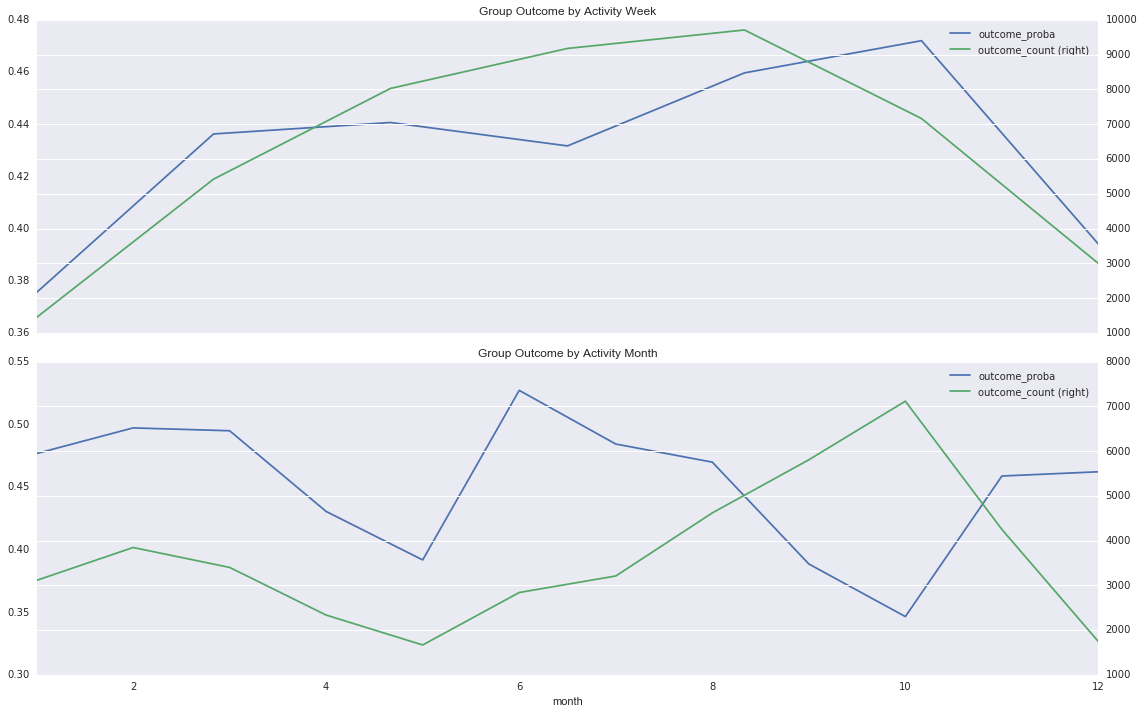

In [538]:
plt.figure()
ax1 = plt.subplot(2,1,1)
week_act.plot(secondary_y='outcome_count', figsize=(16, 10), ax=ax1)
ax1.set_title('Group Outcome by Activity Week')
           
ax2 = plt.subplot(2,1,2)
month_act.plot(secondary_y='outcome_count', figsize=(16, 10), ax=ax2)
ax2.set_title('Group Outcome by Activity Month')


plt.tight_layout()
plt.show()
plt.close()

- It turns out the outcome follows similar weekly trend and most opposit montly trend(after May) in proba and count 

In [539]:
sample_data['dayofweek']= sample_data['date_ppl'].dt.dayofweek
week_ppl = pd.DataFrame()
week_ppl['outcome_proba'] = sample_data.groupby('dayofweek')['outcome'].mean()
week_ppl['outcome_count'] = sample_data.groupby('dayofweek')['outcome'].size()

In [540]:
sample_data['month'] = sample_data['date_ppl'].dt.month
month_ppl = pd.DataFrame()
month_ppl['outcome_proba'] = sample_data.groupby('month')['outcome'].mean()
month_ppl['outcome_count'] = sample_data.groupby('month')['outcome'].size()

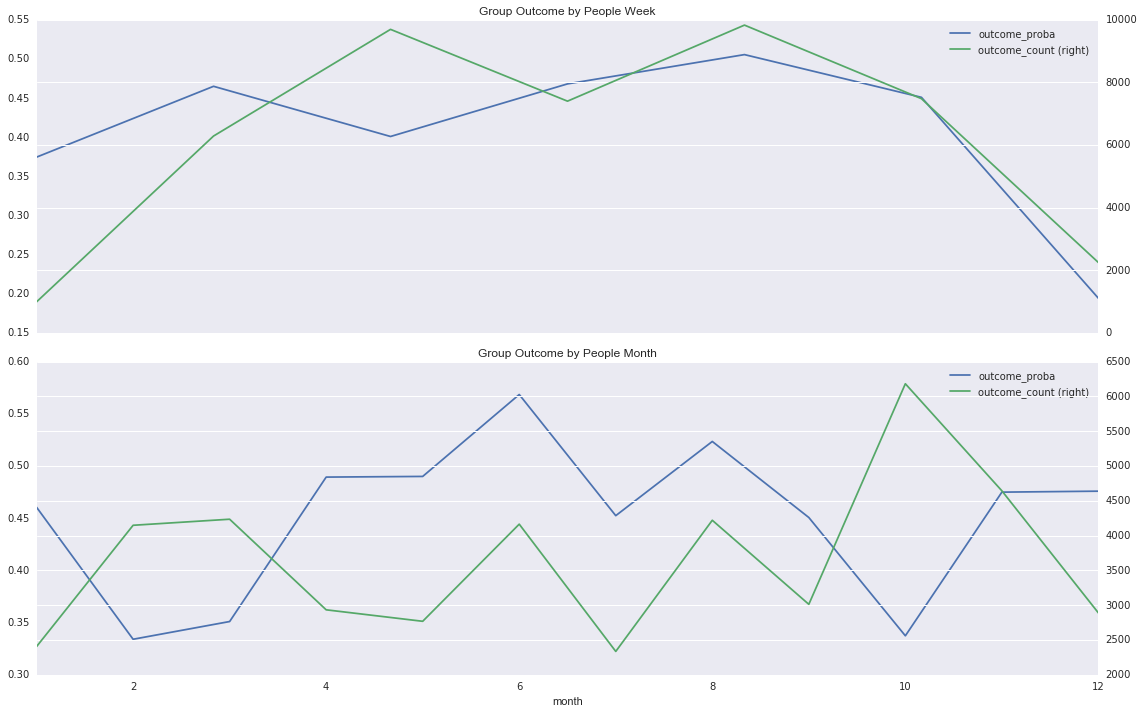

In [541]:
plt.figure()
ax1 = plt.subplot(2,1,1)
week_ppl.plot(secondary_y='outcome_count', figsize=(16, 10), ax=ax1)
ax1.set_title('Group Outcome by People Week')
           
ax2 = plt.subplot(2,1,2)
month_ppl.plot(secondary_y='outcome_count', figsize=(16, 10), ax=ax2)
ax2.set_title('Group Outcome by People Month')


plt.tight_layout()
plt.show()
plt.close()

- The similar weely trend in people dataset as the activity dataset. But, the month trend is quite same beteen May and September rather than after May in activity set.
- Hence, the datetime pattern is important as to the outcome.

### Check 'people_id'

In [542]:
people_id = sample_data.groupby('people_id')['outcome'].mean()
# people_id['outcome_count'] = sample_data.groupby('people_id')['outcome'].size()

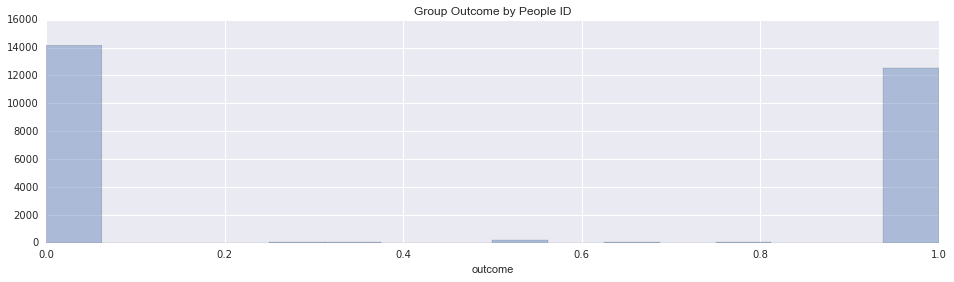

In [543]:
sns.distplot(people_id, kde=False)
sns.plt.title('Group Outcome by People ID')

- It seems like some poeple always go into 0 outcome and some into 1 outcome. And Both almost share the whole outcome.
- If these people exsist in the test set, we definately going to get the outcome. I'm not sure if it's one leakage.

### Check 'people_id' and 'activity_id' in the test set

In [450]:
activity_test = pd.read_csv('./data/act_test.csv', parse_dates=['date'])

In [470]:
leakage_ppl_id = set(activity_test.people_id).intersection(set(people.people_id))
len(leakage_ppl_id)

37823

In [464]:
set(activity_test.activity_id).intersection(set(activity.activity_id))

set()

- There are 37,823 people of train set appearing in the test set.
- Meanwhile, no train activity id is showing in the test set, in another way, some people from the train set will do the different activities in the test set. 

### Drop the sample data and save out the train data

In [519]:
train_data = data.drop(random_idx, axis=0)
train_data.shape

(2153346, 55)

In [520]:
train_data.to_csv('./train_data.csv', index=False)